# 소개

국제적인 전자상거래 기업이 고객 데이터베이스로부터 핵심 인사이트를 도출하고자 합니다. 이 기업은 고객을 분석하기 위해 최신 머신러닝 기법을 활용하려고 하며, 전자 제품을 판매하고 있습니다.

<font color="blue">
내용:

1. [데이터 로드 및 확인](#1)
1. [데이터셋 설명](#2)
    * [변수 설명](#3)
    * [단변량 변수 분석](#4)
        * [범주형 변수 분석](#5)
        * [수치형 변수 분석](#6)

1. [기본 데이터 분석](#7)
1. [이상치 탐지](#8)
    * [Z-점수](#9)
    * [이상치 제거](#10)
    * [윈저라이제이션](#11)
1. [특성 공학](#12)
1. [예측](#13)
1. [하이퍼파라미터 튜닝 - GridSearchCV](#14)
1. [결론](#15)


In [ ]:
# 이 Python 3 환경에는 유용한 데이터 분석 라이브러리들이 이미 설치되어 있습니다.
# Kaggle의 python Docker 이미지에서 정의된 환경입니다: https://github.com/kaggle/docker-python
# 예를 들어, 아래에는 로드할 수 있는 몇 가지 유용한 패키지들이 있습니다.

import numpy as np  # 선형대수 연산
import pandas as pd  # 데이터 처리, CSV 파일 입출력 (예: pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
plt.style.use("seaborn-v0_8-whitegrid")

import seaborn as sns
from collections import OrderedDict
cmaps = OrderedDict()

import warnings
warnings.filterwarnings("ignore")  # 경고 메시지 무시

# 입력 데이터 파일들은 읽기 전용 "../input/" 디렉토리에 저장되어 있습니다.
# 예를 들어, 아래 코드를 실행하면(실행 버튼 클릭 또는 Shift+Enter)
# input 디렉토리 아래에 있는 모든 파일 목록을 출력합니다.

import os
for dirname, _, filenames in os.walk('../data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 현재 디렉토리(/kaggle/working/)에는 최대 20GB까지 파일을 저장할 수 있으며,
# "Save & Run All"을 사용해 버전을 생성하면 해당 파일들은 출력 결과로 보존됩니다.
# 또한 /kaggle/temp/ 디렉토리에 임시 파일을 저장할 수도 있지만,
# 이 파일들은 현재 세션이 종료되면 저장되지 않습니다.


./data\processed_train.csv
./data\Train.csv
./data\Train_FE.csv


<a id="1"></a><br>
# 데이터 로드 및 확인

In [ ]:
#load data
df = pd.read_csv("../data/Train.csv")
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


자, `info()` 메서드를 사용해 데이터의 전체적인 구조를 살펴보겠습니다. 이를 통해 각 변수의 자료형과 결측값(null 데이터)이 존재하는지 확인할 수 있습니다.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


`describe()` 메서드를 사용하면 평균(mean), 표준편차(std), 1사분위수와 2사분위수(중앙값) 등과 같은 기본적인 통계 정보를 빠르게 확인할 수 있습니다.

In [50]:
df.describe()

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


In [51]:
df.columns

Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
       'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
       'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
       'Reached.on.Time_Y.N'],
      dtype='object')

이 데이터셋에는 총 12개의 컬럼이 있습니다. 각 컬럼이 무엇을 의미하는지는 변수 설명 섹션에서 확인하겠습니다. 계속 진행해봅시다!

<a id="2"></a>
# 데이터셋 설명

<a id="3"></a>
## 변수 설명

모델 구축에 사용된 데이터셋은 12개의 변수로 이루어진 10,999개의 관측치를 포함하고 있습니다.  
데이터에는 다음과 같은 정보가 포함되어 있습니다.

1. **ID**: 고객의 고유 식별 번호  
2. **Warehouse block**: 회사의 대형 창고는 A, B, C, D, E와 같은 여러 블록으로 나뉘어 있음  
3. **Mode of shipment**: 배송 방식으로 Ship(선박), Flight(항공), Road(육상) 등이 있음  
4. **Customer care calls**: 배송 관련 문의를 위해 고객이 고객센터에 전화한 횟수  
5. **Customer rating**: 고객이 부여한 평점으로, 1은 가장 낮은 점수(최악), 5는 가장 높은 점수(최고)를 의미함  
6. **Cost of the product**: 제품의 가격(미국 달러 기준)  
7. **Prior purchases**: 이전 구매 횟수  
8. **Product importance**: 제품의 중요도를 low, medium, high와 같은 범주로 분류  
9. **성별**: 남성(Male) 또는 여성(Female)  
10. **Discount offered**: 해당 제품에 적용된 할인율  
11. **Weight in gms**: 제품의 무게(그램 단위)  
12. **Reached on time**: 목표 변수로, 1은 제품이 제시간에 도착하지 않았음을 의미하고, 0은 제시간에 도착했음을 의미함


<a id="4"></a>
# 단변량 변수 분석

* **범주형 변수**: Warehouse block, Customer rating, Mode of shipment, Product importance, 성별, Reached on time(목표 변수)
* **수치형 변수**: ID, Customer care calls, Cost of the product, Prior purchases, Discount offered, Weight in gms

본 데이터셋에는 총 6개의 범주형 변수와 6개의 수치형 변수가 있습니다.


<a id="5"></a>
## 범주형 변수 분석

In [52]:
def categorical_vis(variable):
    
    var = df[variable].value_counts()
    
    x = var.index
    y = var
    if variable == "Reached.on.Time_Y.N":
        plt.bar(x,y,edgecolor="#1F1F1F",color='#636363')
        plt.title(variable,fontsize=12,fontweight="bold",color="#1F1F1F")
        plt.ylabel("Frequency")
        plt.xticks([0,1])
        plt.show()
        print("{}: \n {}".format(variable,var))
    else:
        plt.bar(x,y,edgecolor="#1F1F1F",color='#636363')
        plt.title(variable,fontsize=12,fontweight="bold",color="#1F1F1F")
        plt.ylabel("Frequency")
        plt.show()
        print("{}: \n {}".format(variable,var))

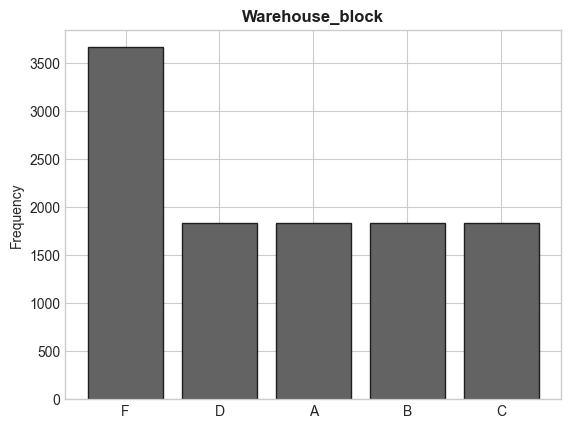

Warehouse_block: 
 Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64


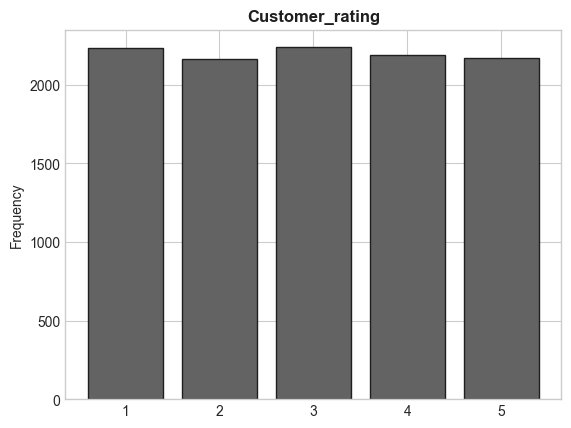

Customer_rating: 
 Customer_rating
3    2239
1    2235
4    2189
5    2171
2    2165
Name: count, dtype: int64


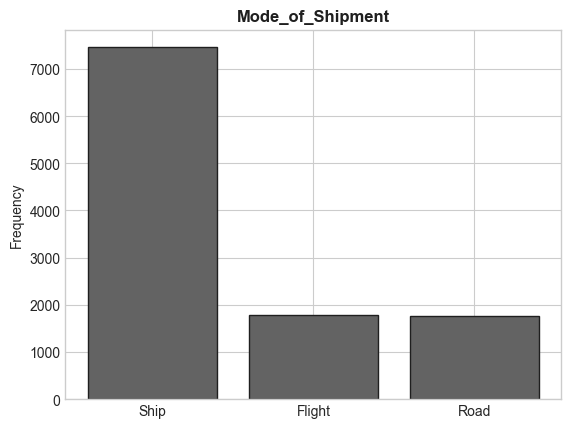

Mode_of_Shipment: 
 Mode_of_Shipment
Ship      7462
Flight    1777
Road      1760
Name: count, dtype: int64


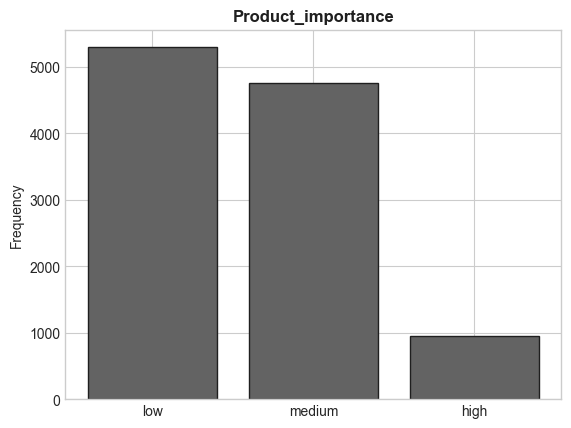

Product_importance: 
 Product_importance
low       5297
medium    4754
high       948
Name: count, dtype: int64


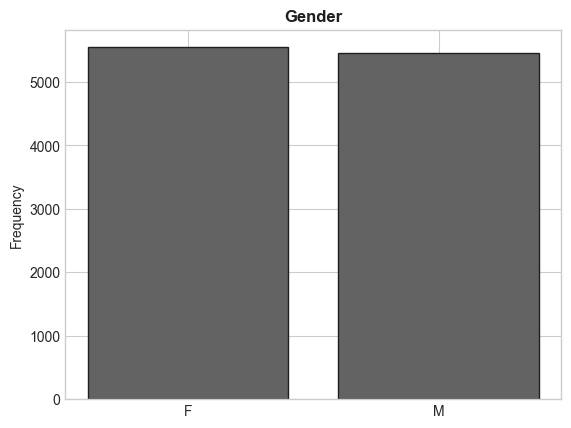

Gender: 
 Gender
F    5545
M    5454
Name: count, dtype: int64


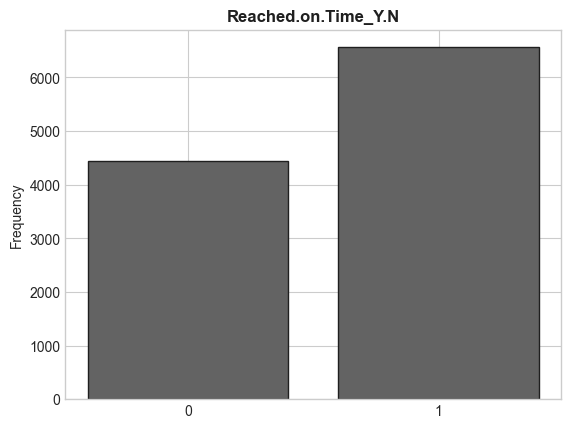

Reached.on.Time_Y.N: 
 Reached.on.Time_Y.N
1    6563
0    4436
Name: count, dtype: int64


In [53]:
categorical = ["Warehouse_block","Customer_rating","Mode_of_Shipment","Product_importance","Gender","Reached.on.Time_Y.N"]
for cat in categorical:
    categorical_vis(cat)

대부분의 배송이 제시간에 도착하지 않았음을 확인할 수 있습니다(제시간 도착: 4,436건, 지연 도착: 6,563건).

또한 배송 방식에서는 선박(Ship)이 가장 큰 비중을 차지하고 있습니다.

따라서 다른 배송 방식에 비해 선박 배송이 상대적으로 느리기 때문에, 지연된 배송의 상당 부분이 선박 배송에서 발생했을 가능성이 있다고 해석할 수 있습니다.


<a id="6"></a>
## 수치형 변수 분석

In [54]:
def numerical_vis(variable):
    plt.figure(figsize = (9,3))
    plt.hist(df[variable],bins=50,color='#636363')
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable),fontsize=12,fontweight="bold",color="#1F1F1F")
    plt.show()

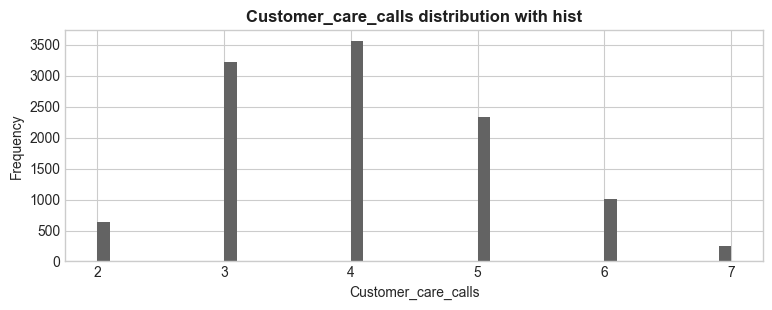

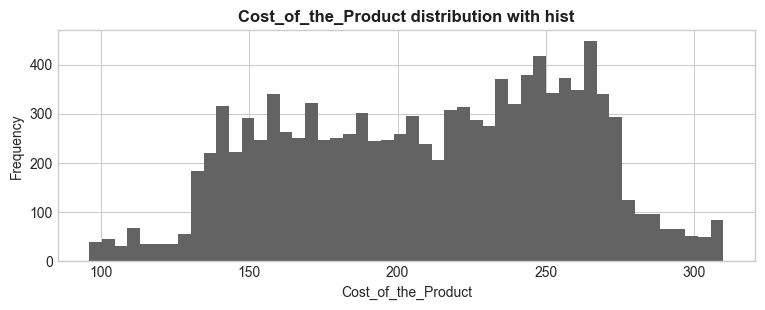

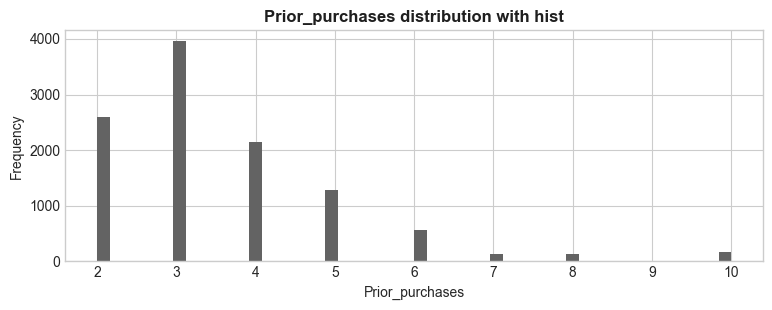

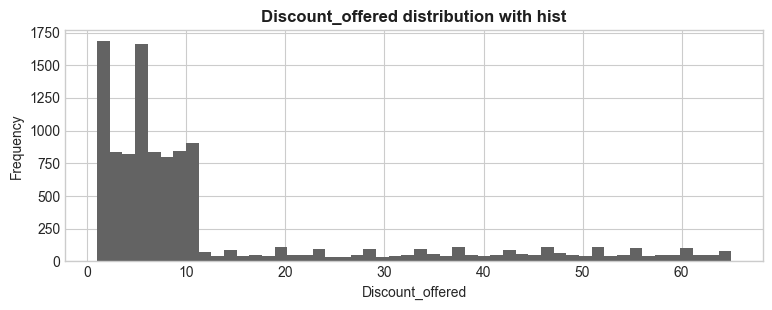

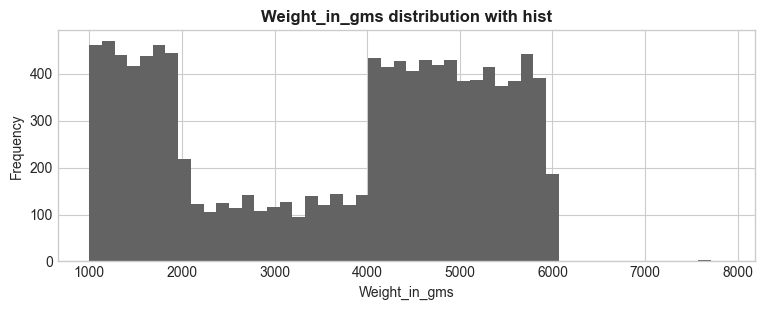

In [55]:
numerical = ["Customer_care_calls","Cost_of_the_Product","Prior_purchases","Discount_offered","Weight_in_gms"]
for num in numerical:
    numerical_vis(num)

<a id="7"></a>
## 기본 데이터 분석

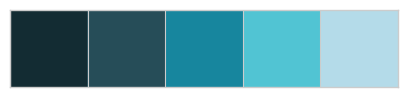

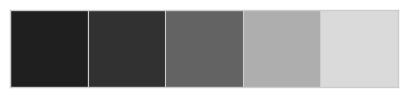

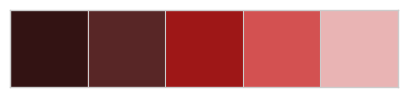

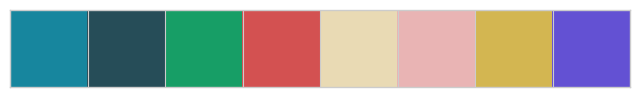

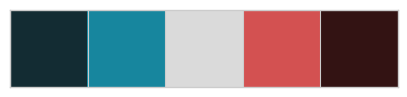

In [56]:
colors_blue = ["#132C33", "#264D58", '#17869E', '#51C4D3', '#B4DBE9']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_mix = ["#17869E", '#264D58', '#179E66', '#D35151', '#E9DAB4', '#E9B4B4', '#D3B651', '#6351D3']
colors_div = ["#132C33", '#17869E', '#DADADA', '#D35151', '#331313']
sns.set_palette("mako")

sns.palplot(colors_blue)
sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_mix)
sns.palplot(colors_div)

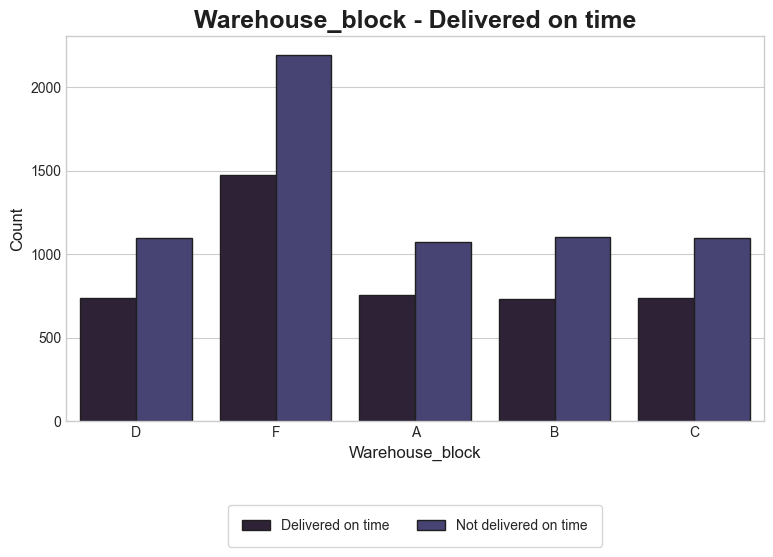

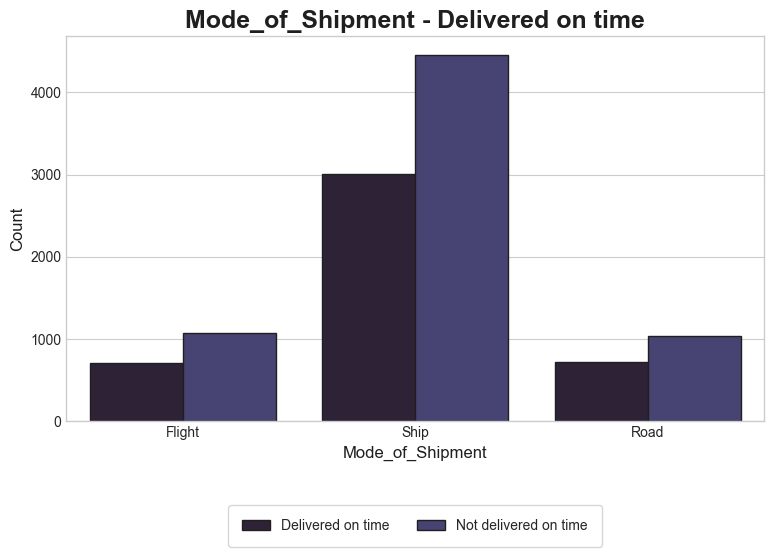

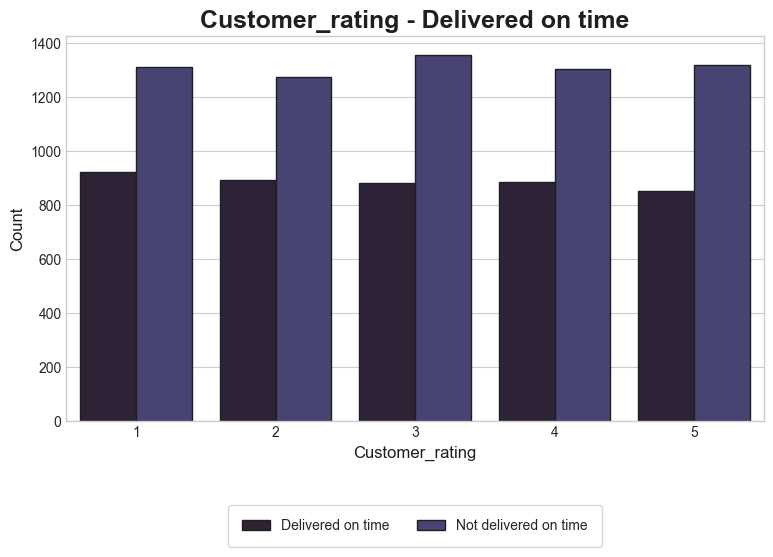

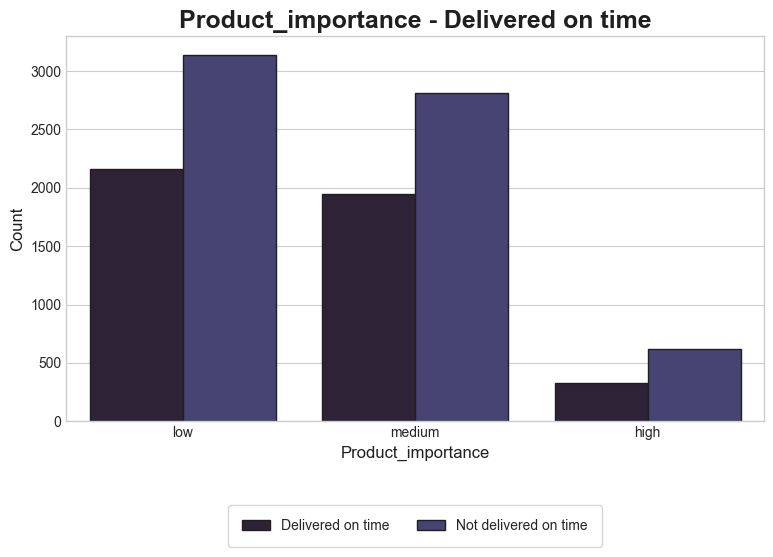

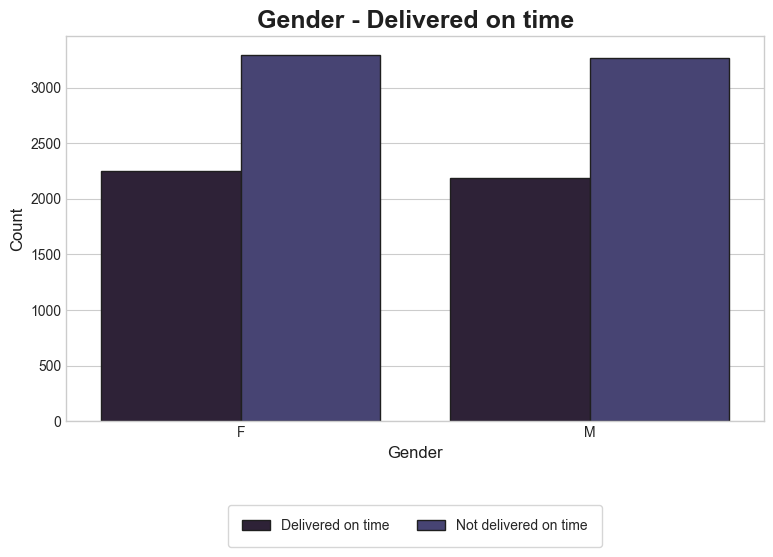

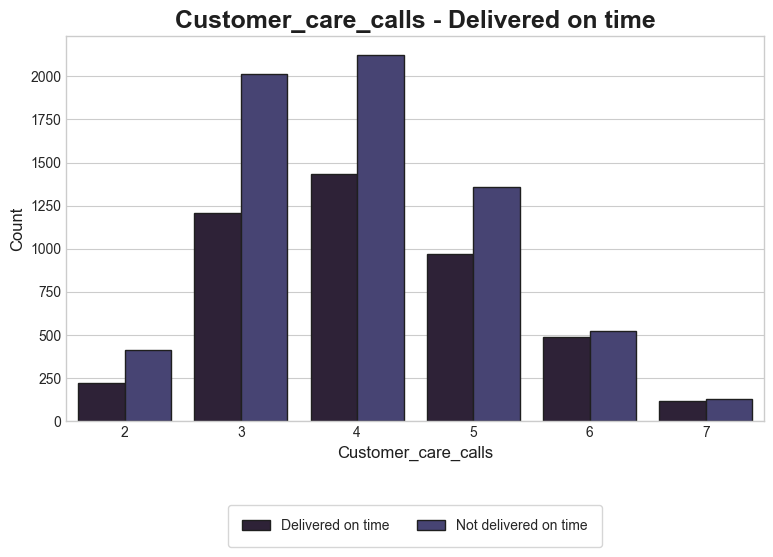

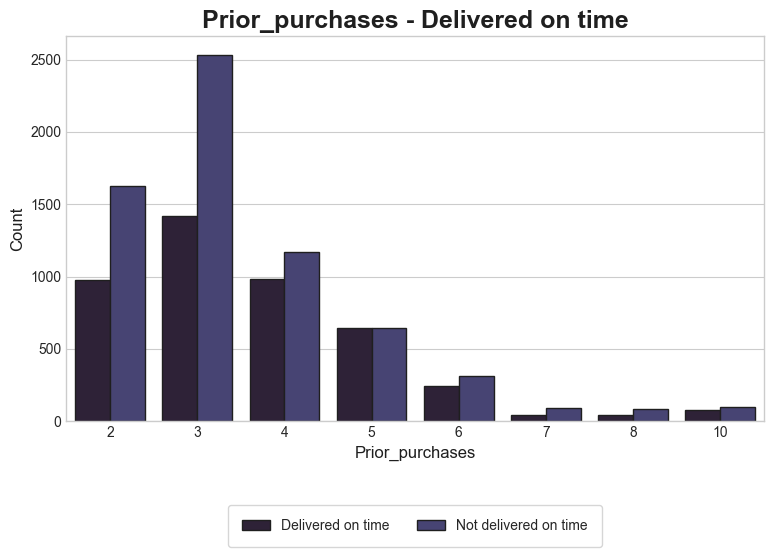

In [57]:
features = ["Warehouse_block","Mode_of_Shipment","Customer_rating","Product_importance","Gender","Customer_care_calls","Prior_purchases"]

for f in features:
    fig, ax = plt.subplots(figsize=(9, 5))
    sns.countplot(x=f,data=df,hue="Reached.on.Time_Y.N",edgecolor=colors_dark[0])
    ax.legend(["Delivered on time","Not delivered on time"],loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderpad=1, frameon=True, fontsize=10)
    plt.ylabel("Count",fontsize=12, fontweight='light', color=colors_dark[0])
    plt.xlabel(f"{f}",fontsize=12, fontweight='light', color=colors_dark[0])
    plt.title("{} - Delivered on time".format(f), fontsize=18, fontweight='bold', color=colors_dark[0])
    plt.show()

- **고객센터에 6~7회 정도 문의한 고객**은 배송이 제시간에 도착할 확률이 더 높습니다.  
- **이전 구매 횟수가 4~6회인 고객**은 배송이 제시간에 도착할 확률이 더 높습니다.

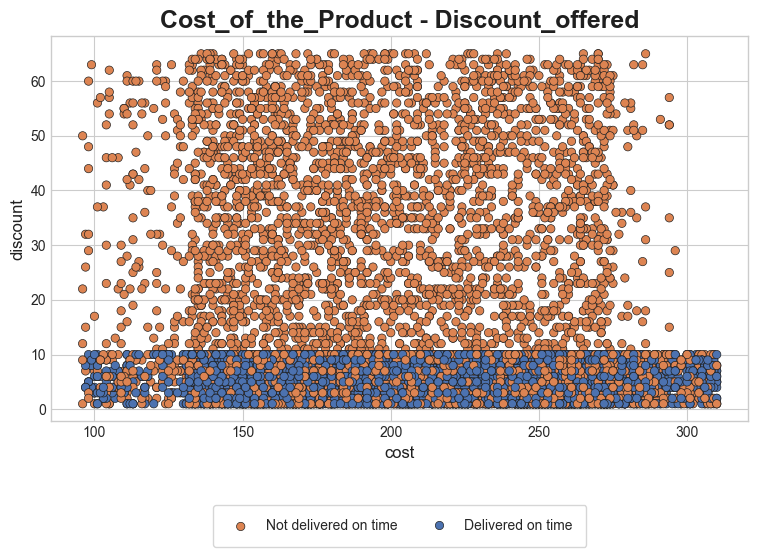

In [58]:
fig, ax = plt.subplots(figsize=(9,5))
sns.scatterplot(x="Cost_of_the_Product",y="Discount_offered",hue="Reached.on.Time_Y.N",data=df,edgecolor=colors_dark[0],palette="deep")
ax.legend(["Not delivered on time","Delivered on time"],loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderpad=1, frameon=True, fontsize=10)
plt.ylabel("discount",fontsize=12, fontweight='light', color=colors_dark[0])
plt.xlabel("cost",fontsize=12, fontweight='light', color=colors_dark[0])
plt.title("Cost_of_the_Product - Discount_offered", fontsize=18, fontweight='bold', color=colors_dark[0])
plt.show()

- **10달러 이상의 할인을 받은 고객**은 제시간에 배송을 받지 못한 경우가 많았습니다.  
- 이 변수는 **배송 지연 예측**에 중요한 특징이 될 것입니다.

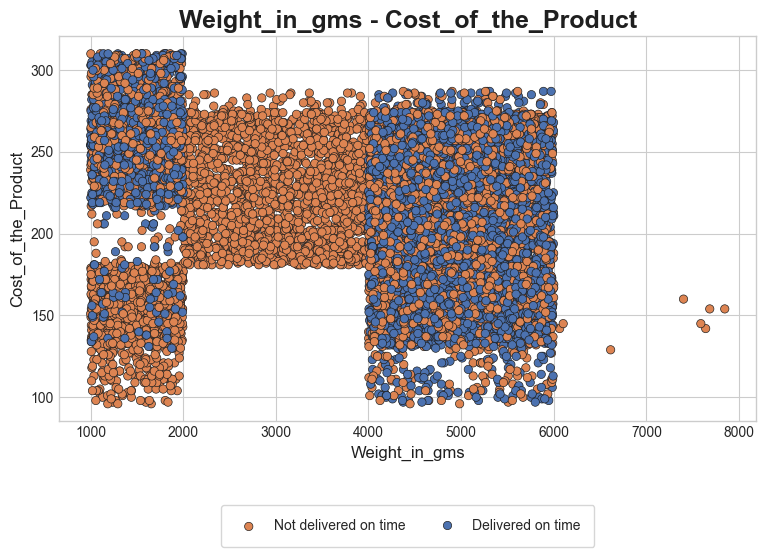

In [59]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.scatterplot(x="Weight_in_gms",y="Cost_of_the_Product",hue="Reached.on.Time_Y.N",data=df,edgecolor=colors_dark[0],palette="deep")
ax.legend(["Not delivered on time","Delivered on time"],loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderpad=1, frameon=True, fontsize=10)
plt.ylabel("Cost_of_the_Product",fontsize=12, fontweight='light', color=colors_dark[0])
plt.xlabel("Weight_in_gms",fontsize=12, fontweight='light', color=colors_dark[0])
plt.title("Weight_in_gms - Cost_of_the_Product", fontsize=18, fontweight='bold', color=colors_dark[0])
plt.show()

- **2,000~4,000g 및 6,000g 이상 제품**은 매번 제시간에 배송되지 않았습니다.  
- **제시간에 배송된 제품**의 무게는 대체로 **1,000~2,000g**과 **4,000~6,000g** 사이에서 분포합니다.

In [60]:
rate_mean = []
avg = df["Customer_rating"].mean()
for i in range(2,8):
    rate_mean.append(float(df[df["Customer_care_calls"]==i]["Customer_rating"].mean()))
    
calls=df.Customer_care_calls.sort_values(ascending=True).unique()

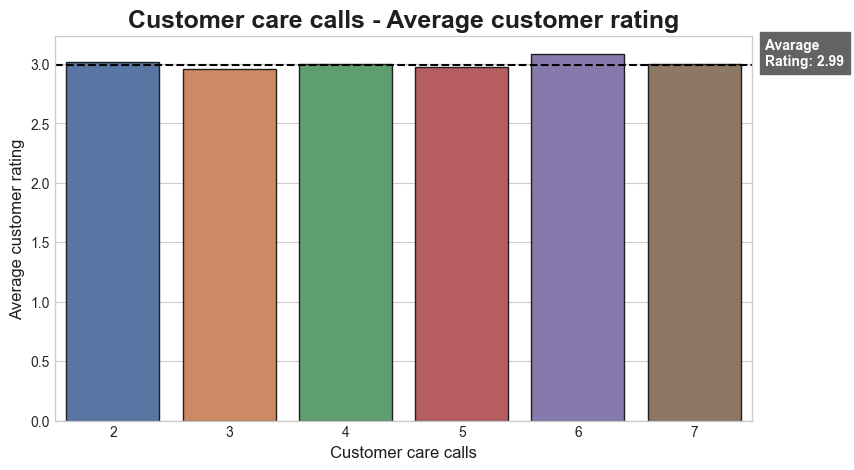

In [61]:
df[df["Customer_care_calls"]==i]["Customer_rating"].mean()
fig, ax = plt.subplots(figsize=(9, 5))
sns.barplot(x=calls,y=rate_mean,edgecolor=colors_dark[0],palette="deep")
ax.axhline(avg, linestyle='--', color="black")
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.text(
    s="Avarage\nRating: {:.2f}".format(avg),
    x=xmax*1.02,
    y=avg,
    backgroundcolor=colors_dark[2],
    fontsize=10,
    fontweight='bold',
    color='white'
)
plt.ylabel("Average customer rating",fontsize=12, fontweight='light', color=colors_dark[0])
plt.xlabel("Customer care calls",fontsize=12, fontweight='light', color=colors_dark[0])
plt.title("Customer care calls - Average customer rating", fontsize=18, fontweight='bold', color=colors_dark[0])
plt.show()

- 두 변수 사이에는 **의미 있는 차이가 없습니다**.  
- 보시다시피, 고객센터에 더 많이 연락한다고 해서 **평점이 더 높아지지는 않습니다**.

<Axes: >

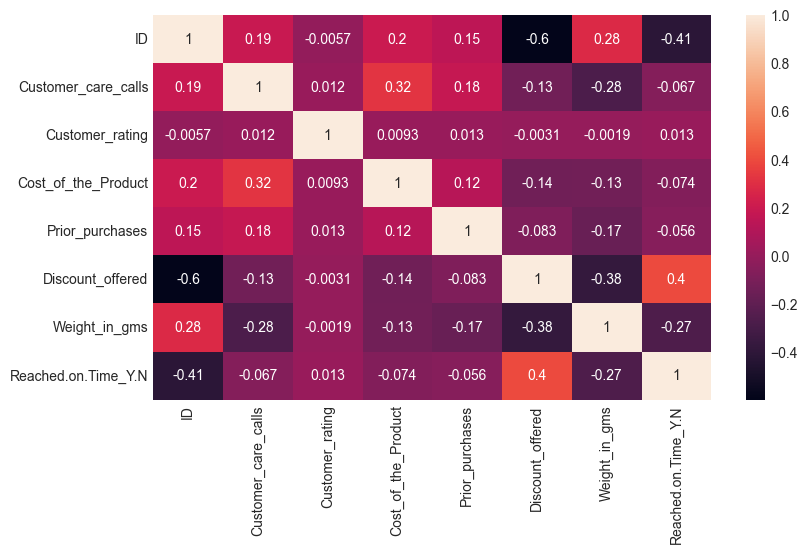

In [62]:
plt.figure(figsize=(9,5))
sns.heatmap(df.corr(numeric_only=True),annot=True)

- **상관관계 행렬(Correlation matrix)** 은 변수들 간의 관계를 보여줍니다.  
  우리가 해석한 바에 따르면, **고객에게 10달러 이상의 할인을 제공하면 해당 주문은 제시간에 도착하지 않을 가능성이 높습니다**.  
  보시다시피, **배송 지연 여부(Reached on Time)** 와 **할인율(Discount Offered)** 사이에는 상관관계가 있습니다.  
  할인율이 올라가면 제시간 도착 확률이 낮아집니다.  
  처음에는 직관과 다르게 느껴질 수 있지만, 여기서 1은 **제시간에 도착하지 않음** , 0은 **제시간에 도착함** 을 의미합니다.

- **제품 가격(Cost of product)** 과 **고객센터 문의 횟수(Customer care calls)** 는 다른 변수들 간의 관계보다 더 강한 상관관계를 보입니다.  
  즉, **제품 가격이 높을수록 고객이 고객센터에 문의할 가능성이 높다** 는 의미입니다.


<a id="8"></a>
# 이상치 탐지

이번 섹션에서는 **이상치(Outlier) 값이 있는지 확인**하고,  
만약 존재한다면 **어떻게 처리할지**에 대해 살펴보겠습니다.

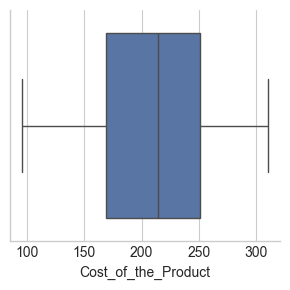

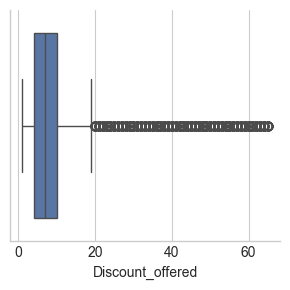

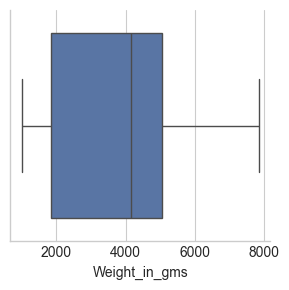

In [63]:
boxes = ["Cost_of_the_Product","Discount_offered","Weight_in_gms"]
for bx in boxes:
    g = sns.FacetGrid(df)
    g.map(sns.boxplot, bx,palette="deep")
    plt.show()

- **할인율(Discount Offered)** 변수에는 많은 이상치가 있는 것으로 보입니다.  
- 다른 변수에도 일부 이상치가 있을 수 있습니다.  
- 이제 **Z-점수(Z-score)를 사용해 이상치를 찾아봅시다!**


<a id="9"></a>
## Z_score

- **Z-점수(Z-score)를 사용하여 이상치가 몇 개인지 확인**하겠습니다.  
- 이상치를 찾는 다른 방법으로 **Tukey 방법**도 사용할 수 있지만,  
  이전 프로젝트(Titanic EDA)에서 이미 사용했기 때문에 이번에는 **Z-점수 방법**으로 진행하겠습니다.


In [64]:
#import
from scipy.stats import zscore

for i in boxes:
    print(i)
    z_scores = zscore(df[i])
    print("*"*50)
    for threshold in np.arange(1.5,5,0.5):
        print("Treshold: {}".format(threshold))
        print("Amount of Outliers: {}".format(len((np.where(z_scores > threshold)[0]))))
        print('------')

Cost_of_the_Product
**************************************************
Treshold: 1.5
Amount of Outliers: 454
------
Treshold: 2.0
Amount of Outliers: 66
------
Treshold: 2.5
Amount of Outliers: 0
------
Treshold: 3.0
Amount of Outliers: 0
------
Treshold: 3.5
Amount of Outliers: 0
------
Treshold: 4.0
Amount of Outliers: 0
------
Treshold: 4.5
Amount of Outliers: 0
------
Discount_offered
**************************************************
Treshold: 1.5
Amount of Outliers: 1382
------
Treshold: 2.0
Amount of Outliers: 999
------
Treshold: 2.5
Amount of Outliers: 584
------
Treshold: 3.0
Amount of Outliers: 181
------
Treshold: 3.5
Amount of Outliers: 0
------
Treshold: 4.0
Amount of Outliers: 0
------
Treshold: 4.5
Amount of Outliers: 0
------
Weight_in_gms
**************************************************
Treshold: 1.5
Amount of Outliers: 7
------
Treshold: 2.0
Amount of Outliers: 5
------
Treshold: 2.5
Amount of Outliers: 1
------
Treshold: 3.0
Amount of Outliers: 0
------
Treshold: 

- 예상대로, **가장 많은 이상치가 "discount_offered" 컬럼**에서 나타났습니다.  
- 이상치를 처리하기 위해 **두 가지 방법**을 사용할 예정입니다.  
  1. 데이터에서 이상치를 **제거(Drop)**  
  2. **윈저라이제이션(Winsorize)** 을 적용하여 이상치를 조정  

- 이후에는 두 방법 중 **어떤 데이터셋이 예측 성능에 더 좋은 결과를 주는지 비교**할 것입니다.


<a id="10"></a>
### 이상치 무시

In [65]:
for i in boxes:
    z_scores = zscore(df[i])
    print(z_scores)

[-0.69072171  0.12074558 -0.56588059 ...  0.66172378  0.26639356
 -1.14847249]
[ 1.88998336  2.81563557  2.13682395 ... -0.57842252 -0.70184282
 -0.45500223]
[-1.46823975 -0.33389333 -0.15900218 ... -1.51593733 -1.48230442
 -1.2199677 ]


In [66]:
for i in boxes:
    z_scores = zscore(df[i])
    df["z_scores_{}".format(i)] = z_scores
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,z_scores_Cost_of_the_Product,z_scores_Discount_offered,z_scores_Weight_in_gms
0,1,D,Flight,4,2,177,3,low,F,44,1233,1,-0.690722,1.889983,-1.468240
1,2,F,Flight,4,5,216,2,low,M,59,3088,1,0.120746,2.815636,-0.333893
2,3,A,Flight,2,2,183,4,low,M,48,3374,1,-0.565881,2.136824,-0.159002
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1,-0.711529,-0.208162,-1.502484
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1,-0.545074,2.013404,-0.703244


In [67]:
indeces = df[(df["z_scores_Cost_of_the_Product"]>=2) | (df["z_scores_Discount_offered"]>=2) | (df["z_scores_Weight_in_gms"]>=2)].index.to_list()
cleaned_data = df

for i in indeces:
    cleaned_data = cleaned_data.drop(index=i,axis=0)

cleaned_data[(cleaned_data["z_scores_Cost_of_the_Product"]>=2) | (cleaned_data["z_scores_Discount_offered"]>=2) | (cleaned_data["z_scores_Weight_in_gms"]>=2)]

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,z_scores_Cost_of_the_Product,z_scores_Discount_offered,z_scores_Weight_in_gms


- 이상치를 제거한 후 데이터에 **새 이름(cleaned_data)**을 부여했습니다.  
- Z-점수(Z-score)가 2를 초과하는 행이 있는지 확인해보면, **더 이상 존재하지 않음을 확인**할 수 있습니다.  
- 즉, 이상치를 성공적으로 제거한 것입니다. 야호!


In [68]:
#Dropping z_score columns
df.drop(columns=["z_scores_Cost_of_the_Product","z_scores_Discount_offered","z_scores_Weight_in_gms"],axis=1,inplace=True)
cleaned_data.drop(columns=["z_scores_Cost_of_the_Product","z_scores_Discount_offered","z_scores_Weight_in_gms"],axis=1,inplace=True)

<a id="11"></a>
### 윈저라이제이션

- 박스 플롯(Box plot)을 확인해보니, **이상치가 높은 값 쪽에만 존재**함을 알 수 있습니다.  
- 따라서 **한쪽(Winsorization One-Sided) 윈저라이제이션**을 적용할 예정이며, 상위 10% 이상을 0.90 분위수로 조정할 것입니다.  
- 시작해봅시다!
``

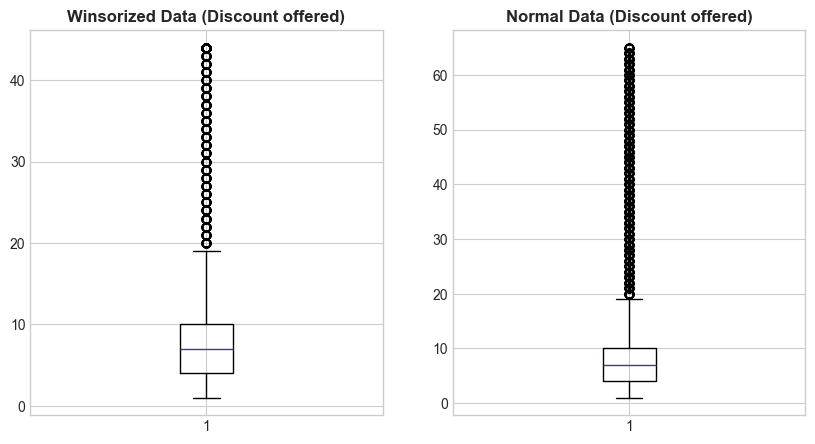

In [70]:
#import
from scipy.stats.mstats import winsorize

winsorized= winsorize(df["Discount_offered"],(0,0.10))

#Visualization
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.boxplot(winsorized)
plt.title("Winsorized Data (Discount offered)",fontsize=12,fontweight="bold")
plt.subplot(1,2,2)
plt.boxplot(df["Discount_offered"].values)
plt.title("Normal Data (Discount offered)",fontsize=12,fontweight="bold")
plt.show()

- 윈저라이제이션을 적용한 후 **이상치가 눈에 띄게 감소**했습니다.  
- 이를 **새로운 데이터프레임(winsorized_data)** 에 저장하겠습니다.

In [71]:
winsorized_data = df
winsorized_data["Discount_offered"] = winsorized
winsorized_data.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,44,3088,1
2,3,A,Flight,2,2,183,4,low,M,44,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,44,2484,1


<a id="12"></a>
## 피처 엔지니어링

In [72]:
# Feature extraction - Discount Rate
new = winsorized_data["Cost_of_the_Product"]/winsorized_data["Weight_in_gms"]
winsorized_data["discount_rate"] = new.values

In [73]:
#one hot encoding
cleaned_data = pd.get_dummies(cleaned_data, columns=["Warehouse_block","Mode_of_Shipment","Gender"])
#label encoding
cleaned_data["Product_importance"].replace({"low":0,"medium":1,"high":2},inplace=True)
cleaned_data["Reached.on.Time_Y.N"].replace({1:0,0:1},inplace=True)
#Drop ID column
cleaned_data.drop(columns=["ID"],axis=1,inplace=True)

#one hot encoding
winsorized_data = pd.get_dummies(winsorized_data, columns=["Warehouse_block","Mode_of_Shipment","Gender"])
#label encoding
winsorized_data["Product_importance"].replace({"low":0,"medium":1,"high":2},inplace=True)
winsorized_data["Reached.on.Time_Y.N"].replace({1:0,0:1},inplace=True)
#Drop ID column
winsorized_data.drop(columns=["ID"],axis=1,inplace=True)

winsorized_data.reset_index(drop=True,inplace=True)
cleaned_data.reset_index(drop=True,inplace=True)

- 예측 모델링을 위해 **범주형 변수에는 One-Hot Encoding**,  
  **"Product_importance" 변수에는 Label Encoding**을 적용했습니다.  

- 또한, 기존에 **배송 제시간 여부(Reached on Time)** 에서 1이 "아니오(NO)", 0이 "예(YES)"로 되어 있어 혼동이 있었기 때문에,  
  이를 **0 = "NO", 1 = "YES"**로 변경했습니다.


In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

con_data= cleaned_data[["Customer_care_calls","Cost_of_the_Product","Discount_offered","Weight_in_gms"]]
con_data2= winsorized_data[["Customer_care_calls","Cost_of_the_Product","Discount_offered","Weight_in_gms"]]

X = StandardScaler().fit_transform(con_data)
X2 = StandardScaler().fit_transform(con_data2)

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

sklearn_pca2 = PCA(n_components=2)
Y_sklearn2 = sklearn_pca2.fit_transform(X2)
print("Outliers Deleted Data")
print(sklearn_pca.explained_variance_ratio_)
print("Cumulative:")
value = 0
for i in sklearn_pca.explained_variance_ratio_:
    value += i
    print(value)

print("\n")
print("Winsorized Data")  
print(sklearn_pca2.explained_variance_ratio_)
print("Cumulative:")
value = 0
for i in sklearn_pca2.explained_variance_ratio_:
    value += i
    print(value)

Outliers Deleted Data
[0.39064276 0.3145339 ]
Cumulative:
0.390642764587804
0.7051766656806462


Winsorized Data
[0.37517334 0.33991853]
Cumulative:
0.37517333651607193
0.7150918712928177


In [75]:
pca_new = pd.DataFrame(Y_sklearn,columns=["PC1","PC2"])
pca_new2 = pd.DataFrame(Y_sklearn2,columns=["PC1","PC2"])

clean_pca = pd.concat([cleaned_data,pca_new],axis=1)
clean_pca = clean_pca.drop(columns=["Customer_care_calls","Cost_of_the_Product","Discount_offered","Weight_in_gms"])

win_pca = pd.concat([winsorized_data,pca_new2],axis=1)
win_pca = win_pca.drop(columns=["Customer_care_calls","Cost_of_the_Product","Discount_offered","Weight_in_gms"])

- 각 데이터셋(cleaned_data와 winsorized_data)에 대해 **PCA(주성분 분석)** 를 적용했습니다.  
- 연속형 변수만 선택하여 총 **4개의 컬럼**을 사용했고, 이를 **2개의 컬럼으로 축소**했습니다.  
- 이제 **예측을 진행할 준비가 완료**되었습니다.  

결과가 기대되지 않나요? **출발~!!**


<a id="13"></a>
# 예측

- 4개의 데이터셋에 대해 **3가지 알고리즘**을 사용할 예정입니다.  
  - RandomForestClassifier  
  - KNN (K-Nearest Neighbors)  
  - GradientBoostingClassifier  

- 이후 **각 알고리즘의 성능을 서로 비교**할 것입니다.


In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#non-pca and outliers deleted data
non_cl_y = cleaned_data["Reached.on.Time_Y.N"]
non_cl_X = cleaned_data.drop(["Reached.on.Time_Y.N"],axis=1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(non_cl_X,non_cl_y,test_size=0.33,random_state=123)

#non-pca and winsorized data
non_win_y = winsorized_data["Reached.on.Time_Y.N"]
non_win_X = winsorized_data.drop(["Reached.on.Time_Y.N"],axis=1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(non_win_X,non_win_y,test_size=0.33,random_state=123)

#pca and outliers deleted data
cl_y = clean_pca["Reached.on.Time_Y.N"]
cl_X = clean_pca.drop(["Reached.on.Time_Y.N"],axis=1)

X_train3, X_test3, y_train3, y_test3 = train_test_split(cl_X,cl_y,test_size=0.33,random_state=123)

#pca and winsorized data
win_y = win_pca["Reached.on.Time_Y.N"]
win_X = win_pca.drop(["Reached.on.Time_Y.N"],axis=1)

X_train4, X_test4, y_train4, y_test4 = train_test_split(win_X,win_y,test_size=0.33,random_state=123)


'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4

In [77]:
rf= RandomForestClassifier(max_depth = 7,min_samples_leaf=1,min_samples_split=4,criterion="entropy",random_state=123)

print("non-pca and outliers deleted data")
rf.fit(X_train1,y_train1)
y_pred1 = rf.predict(X_test1)

print(confusion_matrix(y_test1,y_pred1))
print(accuracy_score(y_test1,y_pred1))
print("*"*30)

print("non-pca and winsorized data")
rf.fit(X_train2,y_train2)
y_pred2 = rf.predict(X_test2)

print(confusion_matrix(y_test2,y_pred2))
print(accuracy_score(y_test2,y_pred2))
print("*"*30)

print("pca and outliers deleted data")
rf.fit(X_train3,y_train3)
y_pred3 = rf.predict(X_test3)

print(confusion_matrix(y_test3,y_pred3))
print(accuracy_score(y_test3,y_pred3))
print("*"*30)

print("pca and winsorized data")
rf.fit(X_train4,y_train4)
y_pred4 = rf.predict(X_test4)

print(confusion_matrix(y_test4,y_pred4))
print(accuracy_score(y_test4,y_pred4))

non-pca and outliers deleted data
[[ 814 1014]
 [ 131 1318]]
0.6505950564540739
******************************
non-pca and winsorized data
[[1181  982]
 [ 128 1339]]
0.6942148760330579
******************************
pca and outliers deleted data
[[ 982  846]
 [ 393 1056]]
0.621910283796155
******************************
pca and winsorized data
[[1263  900]
 [ 290 1177]]
0.6721763085399449


In [ ]:
knn= KNeighborsClassifier(n_neighbors=5)

print("non-pca and outliers deleted data")
knn.fit(X_train1,y_train1)
y_pred1 = knn.predict(X_test1)

print(confusion_matrix(y_test1,y_pred1))
print(accuracy_score(y_test1,y_pred1))
print("*"*30)

print("non-pca and winsorized data")
knn.fit(X_train2,y_train2)
y_pred2 = knn.predict(X_test2)

print(confusion_matrix(y_test2,y_pred2))
print(accuracy_score(y_test2,y_pred2))
print("*"*30)

print("pca and outliers deleted data")
knn.fit(X_train3,y_train3)
y_pred3 = knn.predict(X_test3)

print(confusion_matrix(y_test3,y_pred3))
print(accuracy_score(y_test3,y_pred3))
print("*"*30)

print("pca and winsorized data")
knn.fit(X_train4,y_train4)
y_pred4 = knn.predict(X_test4)

print(confusion_matrix(y_test4,y_pred4))
print(accuracy_score(y_test4,y_pred4))

non-pca and outliers deleted data
[[1135  693]
 [ 570  879]]
0.6145865120537076
******************************
non-pca and winsorized data
[[1483  680]
 [ 579  888]]
0.653168044077135
******************************
pca and outliers deleted data
[[1129  699]
 [ 604  845]]
0.6023802258162954
******************************
pca and winsorized data
[[1472  691]
 [ 609  858]]
0.6418732782369146


In [81]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(loss="exponential", n_estimators=90, criterion="friedman_mse", random_state=123)

print("non-pca and outliers deleted data")
GBC.fit(X_train1,y_train1)
y_pred1 = GBC.predict(X_test1)

print(confusion_matrix(y_test1,y_pred1))
print(accuracy_score(y_test1,y_pred1))
print("*"*30)

print("non-pca and winsorized data")
GBC.fit(X_train2,y_train2)
y_pred2 = GBC.predict(X_test2)

print(confusion_matrix(y_test2,y_pred2))
print(accuracy_score(y_test2,y_pred2))
print("*"*30)

print("pca and outliers deleted data")
GBC.fit(X_train3,y_train3)
y_pred3 = GBC.predict(X_test3)

print(confusion_matrix(y_test3,y_pred3))
print(accuracy_score(y_test3,y_pred3))
print("*"*30)

print("pca and winsorized data")
GBC.fit(X_train4,y_train4)
y_pred4 = GBC.predict(X_test4)

print(confusion_matrix(y_test4,y_pred4))
print(accuracy_score(y_test4,y_pred4))

non-pca and outliers deleted data
[[ 848  980]
 [ 147 1302]]
0.6560878852609093
******************************
non-pca and winsorized data
[[1256  907]
 [ 209 1258]]
0.6925619834710743
******************************
pca and outliers deleted data
[[ 936  892]
 [ 315 1134]]
0.6316753127860848
******************************
pca and winsorized data
[[1247  916]
 [ 281 1186]]
0.6702479338842975


- **"PCA를 적용하지 않고 윈저라이즈한 데이터(non-PCA and winsorized data)"** 에서 Random Forest와 Gradient Boosting이 더 좋은 성능을 보여주었습니다.  
- 보시다시피, PCA를 적용했을 때는 **정확도가 약 1% 정도만 감소** 했습니다.  

- 정확도와 정밀도(precision) 점수가 더 높았기 때문에,  
  **Random Forest와 non-PCA 윈저라이즈 데이터** 로 계속 진행할 예정입니다.  
- 이후 **하이퍼파라미터 튜닝(Hyperparameter Tuning)** 을 통해 모델 성능을 개선해보겠습니다.


<a id="14"></a>
## Hyperparamter Tuning - GridSearch CV

In [82]:
rf.get_params()
params = {"max_depth":[x for x in range (3,15)],
         "min_samples_split":[x for x in range (2,5)],
         "min_samples_leaf":[x for x in range (1,3)],
         }

In [83]:
from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(estimator=rf,
                       param_grid = params,
                       cv = 10
                      )
grid_cv.fit(non_win_X, non_win_y)

print("Best Parameters : ", grid_cv.best_params_)

Best Parameters :  {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4}


<a id="15"></a>
# 결론

- 총 4개의 데이터셋을 만들었습니다.  
  - 이상치 제거(cleaned)  
  - 윈저라이즈(winsorized)  
  - 각각의 PCA 버전  

- 결과를 확인해보니, **정확도와 정밀도가 가장 높게 나온 조합은 Random Forest와 non-PCA 윈저라이즈 데이터**였습니다.  
- Random Forest의 최적 파라미터는 **하이퍼파라미터 튜닝(GridSearchCV)**을 통해 찾았습니다.  

- 최종 결과로, **non-PCA 윈저라이즈 데이터와 RandomForestClassifier**를 사용했을 때,  
  약 **69.5%의 정확도(accuracy)**를 달성했습니다.
